In [2]:
import kagglehub

# Download latest version
train_data_path = kagglehub.dataset_download("sparshgoyal421/sarcasm-train")

print("Path to dataset files:", train_data_path)

test_data_path = kagglehub.dataset_download("sparshgoyal421/sarcasm-test")

print("Path to dataset files:", test_data_path)

Path to dataset files: /kaggle/input/sarcasm-train
Path to dataset files: /kaggle/input/sarcasm-test


In [3]:
!pip install torch torchtext torch_geometric transformers senticnet spacy gensim matplotlib seaborn nltk pandas numpy scikit-learn
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 2.4 MB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.7 MB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
# 4) All your imports, ready to go
import os, gc, re, ast
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

from transformers import RobertaTokenizer, RobertaModel, get_linear_schedule_with_warmup

from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from sklearn.utils import resample

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

import networkx as nx
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx

import nltk
from nltk.tokenize import word_tokenize

import spacy
from senticnet.senticnet import SenticNet

import gensim.downloader as gensim_downloader

# (optional) verify versions
print(f"torch: {torch.__version__}  cuda: {torch.version.cuda}")
print(f"transformers: {__import__('transformers').__version__}")
print(f"torch_geometric: {__import__('torch_geometric').__version__}")
print(f"spaCy model: {spacy.load('en_core_web_sm').meta['version']}")


2025-05-07 17:06:46.940209: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746637607.121525      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746637607.172756      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


torch: 2.5.1+cu124  cuda: 12.4
transformers: 4.51.1
torch_geometric: 2.6.1
spaCy model: 3.7.1


In [5]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Enable mixed precision training if GPU is available
if device.type == 'cuda':
    scaler = torch.cuda.amp.GradScaler()
    print("Mixed precision training enabled")

# Download required resources
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

Using device: cuda
Mixed precision training enabled


/tmp/ipykernel_31/2740402023.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [6]:
# Load pre-trained word embeddings (GloVe)
print("Loading GloVe embeddings...")
try:
    glove_embeddings = gensim_downloader.load('glove-wiki-gigaword-300')
    EMBEDDING_DIM = 300
    print(f"Loaded GloVe embeddings with dimension: {EMBEDDING_DIM}")
except Exception as e:
    print(f"Error loading GloVe embeddings: {str(e)}")
    print("Using random embeddings instead")
    glove_embeddings = None
    EMBEDDING_DIM = 300

# Load spaCy model
try:
    nlp = spacy.load("en_core_web_sm")
    print("Loaded spaCy model successfully")
except:
    print("Downloading spaCy model...")
    import subprocess
    subprocess.run(["python", "-m", "spacy", "download", "en_core_web_sm"])
    nlp = spacy.load("en_core_web_sm")

# Initialize SenticNet
try:
    sn = SenticNet()
    print("Loaded SenticNet successfully")
except Exception as e:
    print(f"Error loading SenticNet: {str(e)}")
    sn = None

Loading GloVe embeddings...
[==========================------------------------] 53.4% 200.7/376.1MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=10000.0 (msgs/sec)
NotebookApp.rate_limit_window=1.0 (secs)



[==================================================] 100.0% 376.1/376.1MB downloaded
Loaded GloVe embeddings with dimension: 300
Loaded spaCy model successfully
Loaded SenticNet successfully


In [7]:
class SarcasmGraphDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=128):
        self.tokenizer = tokenizer
        self.comments = df['comment'].values
        self.contexts = df['context'].values
        self.labels = df['label'].values
        self.max_length = max_length
        self.window_size = 2  # Window size for graph construction
        
    def __len__(self):
        return len(self.comments)
    
    def get_embedding(self, word):
        """Get the GloVe embedding for a word"""
        word = word.lower()
        if glove_embeddings and word in glove_embeddings:
            return torch.tensor(glove_embeddings[word], dtype=torch.float)
        else:
            # Use random embedding if word not found
            return torch.randn(EMBEDDING_DIM, dtype=torch.float)
    
    def get_sentiment_features(self, word):
        """Extract sentiment features using SenticNet"""
        try:
            if sn is not None:
                concept_info = sn.concept(word)
                # Extract polarity value (float between -1 and 1)
                polarity = float(concept_info['polarity_value'])
                # Create a 5-dimensional feature: [polarity, is_positive, is_negative, is_neutral, intensity]
                is_positive = 1.0 if polarity > 0.1 else 0.0
                is_negative = 1.0 if polarity < -0.1 else 0.0
                is_neutral = 1.0 if abs(polarity) <= 0.1 else 0.0
                intensity = abs(polarity)
                return torch.tensor([polarity, is_positive, is_negative, is_neutral, intensity], dtype=torch.float)
            else:
                return torch.zeros(5, dtype=torch.float)
        except:
            # Word not found in SenticNet
            return torch.zeros(5, dtype=torch.float)
    
    def create_graph_from_text(self, text):
        """Create a graph representation of text for GCN with enhanced features"""
        # Parse text with spaCy for dependency parsing
        doc = nlp(text.lower())
        
        # Create a graph where nodes are tokens
        G = nx.Graph()
        
        # Store tokens for later embedding lookup
        tokens = [token.text for token in doc]
        
        # Add nodes with positions
        for i, token in enumerate(doc):
            G.add_node(i, word=token.text, pos=token.pos_)
        
        # Add edges based on window and dependencies
        # 1. Window-based edges
        for i in range(len(tokens)):
            for j in range(i+1, min(i+self.window_size+1, len(tokens))):
                G.add_edge(i, j, edge_type=0)  # Type 0: window edge
        
        # 2. Dependency-based edges
        for token in doc:
            if token.i < len(tokens) and token.head.i < len(tokens):
                G.add_edge(token.i, token.head.i, edge_type=1)  # Type 1: dependency edge
                
        # Convert to PyTorch Geometric Data object
        if len(G.nodes) > 0:
            data = from_networkx(G)
            
            # Create feature matrix for nodes [GloVe (25d) + Sentiment (5d)]
            feature_dim = EMBEDDING_DIM + 5
            features = torch.zeros((len(G.nodes), feature_dim), dtype=torch.float)
            
            for i, token_text in enumerate(tokens):
                if i < len(features):
                    # GloVe embedding
                    glove_feature = self.get_embedding(token_text)
                    # Sentiment features
                    sentiment_feature = self.get_sentiment_features(token_text)
                    # Concatenate features
                    if len(glove_feature) == EMBEDDING_DIM and len(sentiment_feature) == 5:
                        features[i] = torch.cat([glove_feature, sentiment_feature])
            
            data.x = features
            return data, tokens
        else:
            # Return empty graph if there are no nodes
            empty_data = Data(x=torch.zeros((1, feature_dim), dtype=torch.float),
                             edge_index=torch.zeros((2, 0), dtype=torch.long))
            return empty_data, []
    
    def __getitem__(self, idx):
        comment = str(self.comments[idx])
        
        # Parse context if it's a string
        if isinstance(self.contexts[idx], str):
            try:
                context_list = ast.literal_eval(self.contexts[idx])
            except:
                context_list = [self.contexts[idx]]
        else:
            context_list = self.contexts[idx]
            
        # Join all context elements
        context = " ".join([str(c) for c in context_list])
        
        # Combine context and comment
        combined_text = f"Context: {context} Comment: {comment}"
        
        # Create graph data with enhanced features
        graph_data, tokens = self.create_graph_from_text(combined_text)
        
        # Encode with truncation and padding for transformer
        encoding = self.tokenizer(
            combined_text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'graph_data': graph_data,
            'tokens': tokens,
            'label': torch.tensor(self.labels[idx], dtype=torch.float)
        }

class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(GCNLayer, self).__init__()
        self.gc = GCNConv(in_features, out_features)
        self.bn = nn.BatchNorm1d(out_features)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x, edge_index):
        x = self.gc(x, edge_index)
        if x.size(0) > 1:  # BatchNorm needs more than 1 element
            x = self.bn(x)
        x = F.relu(x)
        return self.dropout(x)

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=1, bidirectional=True):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, 
                            batch_first=True, bidirectional=bidirectional)
        
    def forward(self, x):
        # x shape: (batch, seq_len, input_dim)
        lstm_out, _ = self.lstm(x)
        # Get the output from the last non-padded element
        last_output = lstm_out[:, -1, :]
        return last_output

class SarcasmGCNLSTMDetector(nn.Module):
    def __init__(self, pretrained_model="roberta-base", gcn_hidden_dim=64, dropout_rate=0.3):
        super(SarcasmGCNLSTMDetector, self).__init__()
        self.roberta = RobertaModel.from_pretrained(pretrained_model)
        self.hidden_dim = self.roberta.config.hidden_size
        
        # Feature dimensions
        feature_dim = EMBEDDING_DIM + 5  # GloVe + Sentiment
        
        # 4-layer GCN as per the paper
        self.gcn1 = GCNLayer(feature_dim, gcn_hidden_dim)
        self.gcn2 = GCNLayer(gcn_hidden_dim, gcn_hidden_dim*2)
        self.gcn3 = GCNLayer(gcn_hidden_dim*2, gcn_hidden_dim*2)
        self.gcn4 = GCNLayer(gcn_hidden_dim*2, gcn_hidden_dim)
        
        # LSTM for sequential processing
        self.lstm = LSTM(gcn_hidden_dim, gcn_hidden_dim//2, bidirectional=True)
        
        # Attention mechanism for combining RoBERTa and GCN-LSTM outputs
        self.attention = nn.Linear(self.hidden_dim + gcn_hidden_dim, 1)
        
        # Final classification layers
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(self.hidden_dim + gcn_hidden_dim, 256)
        self.fc2 = nn.Linear(256, 1)
        
    def forward(self, input_ids, attention_mask, graph_x, graph_edge_index):
        # Process text with RoBERTa
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        roberta_embedding = outputs.pooler_output  # [CLS] token embedding
        
        # Process graph with multi-layer GCN
        x1 = self.gcn1(graph_x, graph_edge_index)
        x2 = self.gcn2(x1, graph_edge_index)
        x3 = self.gcn3(x2, graph_edge_index)
        x4 = self.gcn4(x3, graph_edge_index)
        
        # Prepare for LSTM - reshape if there's a batch
        batch_size = roberta_embedding.shape[0]
        if batch_size > 1:
            # For simplicity, we'll just take the mean of the node embeddings for batched graphs
            gcn_embedding = torch.mean(x4, dim=0).unsqueeze(0)
            gcn_embedding = gcn_embedding.expand(batch_size, -1)
        else:
            # Use LSTM for sequential processing (for single example)
            # Reshape for LSTM: [num_nodes, features] -> [1, num_nodes, features]
            lstm_input = x4.unsqueeze(0)
            gcn_embedding = self.lstm(lstm_input)
        
        # Concatenate RoBERTa and GCN-LSTM embeddings
        combined = torch.cat((roberta_embedding, gcn_embedding), dim=1)
        
        # Apply attention
        attention_weights = torch.sigmoid(self.attention(combined))
        weighted_embedding = combined * attention_weights
        
        # Final classification
        x = self.dropout(weighted_embedding)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        # Output logits (not sigmoid)
        return self.fc2(x)

def collate_batch(batch):
    """Custom collate function for handling graph data"""
    # Extract elements from batch
    input_ids = torch.stack([item['input_ids'] for item in batch])
    attention_mask = torch.stack([item['attention_mask'] for item in batch])
    labels = torch.stack([item['label'] for item in batch])
    tokens_list = [item['tokens'] for item in batch]
    
    # For graph data, we create a simple representation with batch size of 1
    # In a production system, you would use proper batching from PyG
    graph_xs = [item['graph_data'].x for item in batch]
    graph_edge_indices = [item['graph_data'].edge_index for item in batch]
    
    # Use the first graph for simplicity (or you could merge graphs with proper shifts)
    feature_dim = EMBEDDING_DIM + 5  # GloVe + Sentiment
    if len(graph_xs) > 0 and graph_xs[0] is not None and graph_xs[0].numel() > 0:
        graph_x = graph_xs[0]
        graph_edge_index = graph_edge_indices[0]
    else:
        # Fallback for empty graphs
        graph_x = torch.zeros((1, feature_dim), dtype=torch.float)
        graph_edge_index = torch.zeros((2, 0), dtype=torch.long)
    
    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'graph_x': graph_x,
        'graph_edge_index': graph_edge_index,
        'tokens': tokens_list,
        'label': labels
    }

def prepare_balanced_dataset(data_path, sample_size=200000):
    """Prepare a balanced dataset with equal class distribution"""
    print(f"Loading dataset from {data_path}...")
    
    # Read the full dataset 
    df = pd.read_csv(data_path)
    print(f"Total samples in dataset: {len(df)}")
    
    # Get samples for each class
    df_0 = df[df['label'] == 0]
    df_1 = df[df['label'] == 1]
    
    print(f"Class distribution - Class 0: {len(df_0)}, Class 1: {len(df_1)}")
    
    # Calculate how many samples to take from each class
    samples_per_class = min(sample_size // 2, len(df_0), len(df_1))
    print(f"Taking {samples_per_class} samples from each class")
    
    # Resample each class
    df_0_sampled = resample(df_0, n_samples=samples_per_class, random_state=42)
    df_1_sampled = resample(df_1, n_samples=samples_per_class, random_state=42)
    
    # Combine the balanced dataset
    balanced_df = pd.concat([df_0_sampled, df_1_sampled])
    
    # Shuffle the data
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    print(f"Final balanced dataset size: {len(balanced_df)}")
    print(f"Class distribution: {balanced_df['label'].value_counts().to_dict()}")
    
    return balanced_df

def train_model():
    """Train the sarcasm detection model with GCN-LSTM"""
    # File paths
    train_path = "/kaggle/input/sarcasm-train/train.csv"
    test_path = "/kaggle/input/sarcasm-test/test.csv"
    
    # Create output directory for checkpoints
    os.makedirs("checkpoints", exist_ok=True)
    
    # Training parameters
    num_epochs = 4
    batch_size = 16  # Small batch size due to GCN complexity
    gradient_accumulation_steps = 8
    learning_rate = 2e-5
    max_length = 128
    validation_split = 0.1
    
    # Prepare balanced dataset
    balanced_df = prepare_balanced_dataset(train_path, sample_size=809210)
    
    # Initialize tokenizer
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    
    # Train/validation split
    train_size = int((1 - validation_split) * len(balanced_df))
    val_size = len(balanced_df) - train_size
    
    train_df = balanced_df.iloc[:train_size]
    val_df = balanced_df.iloc[train_size:]
    
    print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}")
    
    # Create datasets
    train_dataset = SarcasmGraphDataset(train_df, tokenizer, max_length=max_length)
    val_dataset = SarcasmGraphDataset(val_df, tokenizer, max_length=max_length)
    
    # Create data loaders
    train_dataloader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True,
        num_workers=2,
        pin_memory=True if device.type == 'cuda' else False,
        collate_fn=collate_batch
    )
    
    val_dataloader = DataLoader(
        val_dataset, 
        batch_size=batch_size,
        num_workers=2,
        pin_memory=True if device.type == 'cuda' else False,
        collate_fn=collate_batch
    )
    
    # Initialize model
    model = SarcasmGCNLSTMDetector().to(device)
    
    # Optimizer
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    
    # Learning rate scheduler
    total_steps = len(train_dataloader) * num_epochs // gradient_accumulation_steps
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(total_steps * 0.1),
        num_training_steps=total_steps
    )
    
    # Training loop
    print(f"Starting training for {num_epochs} epochs...")
    best_val_accuracy = 0
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # Training
        model.train()
        train_loss = 0
        optimizer.zero_grad()
        
        progress_bar = tqdm(enumerate(train_dataloader), total=len(train_dataloader), 
                           desc=f"Training epoch {epoch+1}")
        
        for step, batch in progress_bar:
            if device.type == 'cuda':
                # Mixed precision training
                with torch.amp.autocast(device_type='cuda'):
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    graph_x = batch['graph_x'].to(device)
                    graph_edge_index = batch['graph_edge_index'].to(device)
                    labels = batch['label'].to(device)
                    
                    # Forward pass
                    logits = model(
                        input_ids=input_ids, 
                        attention_mask=attention_mask,
                        graph_x=graph_x,
                        graph_edge_index=graph_edge_index
                    )
                    
                    # Calculate loss
                    loss = F.binary_cross_entropy_with_logits(logits.squeeze(), labels)
                    loss = loss / gradient_accumulation_steps
                
                # Backward pass with scaling
                scaler.scale(loss).backward()
                
                if (step + 1) % gradient_accumulation_steps == 0:
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    scaler.step(optimizer)
                    scaler.update()
                    scheduler.step()
                    optimizer.zero_grad()
            else:
                # Standard training without mixed precision
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                graph_x = batch['graph_x'].to(device)
                graph_edge_index = batch['graph_edge_index'].to(device)
                labels = batch['label'].to(device)
                
                # Forward pass
                logits = model(
                    input_ids=input_ids, 
                    attention_mask=attention_mask,
                    graph_x=graph_x,
                    graph_edge_index=graph_edge_index
                )
                
                # Calculate loss
                loss = F.binary_cross_entropy_with_logits(logits.squeeze(), labels)
                loss = loss / gradient_accumulation_steps
                
                # Backward pass
                loss.backward()
                
                if (step + 1) % gradient_accumulation_steps == 0:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    optimizer.step()
                    scheduler.step()
                    optimizer.zero_grad()
            
            train_loss += loss.item() * gradient_accumulation_steps
            
            # Update progress bar
            progress_bar.set_postfix({
                'loss': f"{train_loss/(step+1):.4f}"
            })
            
            # Free up memory
            del input_ids, attention_mask, graph_x, graph_edge_index, labels, logits, loss
            if step % 20 == 0:
                torch.cuda.empty_cache()
                gc.collect()
        
        train_loss /= len(train_dataloader)
        print(f"Training loss: {train_loss:.4f}")
        
        # Evaluation
        model.eval()
        val_preds = []
        val_labels = []
        
        print("Evaluating...")
        with torch.no_grad():
            for batch in tqdm(val_dataloader, desc="Validation"):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                graph_x = batch['graph_x'].to(device)
                graph_edge_index = batch['graph_edge_index'].to(device)
                labels = batch['label'].cpu().numpy()
                
                # Forward pass
                logits = model(
                    input_ids=input_ids, 
                    attention_mask=attention_mask,
                    graph_x=graph_x,
                    graph_edge_index=graph_edge_index
                )
                
                # Get predictions
                preds = (torch.sigmoid(logits.squeeze()) > 0.5).int().cpu().numpy()
                
                val_preds.extend(preds)
                val_labels.extend(labels)
                
                # Free up memory
                del input_ids, attention_mask, graph_x, graph_edge_index, logits
        
        # Calculate accuracy
        val_accuracy = accuracy_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds)
        
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        print(f"Validation F1 Score: {val_f1:.4f}")
        print(classification_report(val_labels, val_preds))
        
        # Save checkpoint if it's the best model so far
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), f"checkpoints/sarcasm_gcn_lstm_detector_best.pt")
            print(f"New best model saved with accuracy: {val_accuracy:.4f}")
        
        # Save regular checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_accuracy': val_accuracy,
        }, f"checkpoints/sarcasm_gcn_lstm_detector_epoch_{epoch+1}.pt")
        
        print(f"Checkpoint saved for epoch {epoch+1}")
        
        # Clear memory
        torch.cuda.empty_cache()
        gc.collect()
    
    print("Training complete!")
    
    # Evaluate on test set
    
    return model

def evaluate_test_set(test_file_path, model_path="checkpoints/sarcasm_gcn_lstm_detector_best.pt", batch_size=8):
    """Evaluate model on test dataset"""
    print(f"\n===== Evaluating on Test Set =====")
    print(f"Loading test data from {test_file_path}...")
    
    # Load test data
    test_df = pd.read_csv(test_file_path)
    print(f"Test data loaded: {len(test_df)} samples")
    
    # Initialize tokenizer
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    
    # Create dataset
    test_dataset = SarcasmGraphDataset(test_df, tokenizer, max_length=128)
    
    # Create dataloader
    test_dataloader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        num_workers=2,
        pin_memory=True if device.type == 'cuda' else False,
        collate_fn=collate_batch
    )
    
    # Load model
    print(f"Loading model from {model_path}...")
    model = SarcasmGCNLSTMDetector().to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    # Evaluation
    all_preds = []
    all_labels = []
    
    print("Running evaluation...")
    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc="Testing"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            graph_x = batch['graph_x'].to(device)
            graph_edge_index = batch['graph_edge_index'].to(device)
            labels = batch['label'].cpu().numpy()
            
            # Forward pass
            logits = model(
                input_ids=input_ids, 
                attention_mask=attention_mask,
                graph_x=graph_x,
                graph_edge_index=graph_edge_index
            )
            
            # Get predictions
            preds = (torch.sigmoid(logits.squeeze()) > 0.5).int().cpu().numpy()
            
            all_preds.extend(preds)
            all_labels.extend(labels)
            
            # Free memory
            del input_ids, attention_mask, graph_x, graph_edge_index, logits
            
        # Clear GPU memory
        torch.cuda.empty_cache()
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    
    print("\n===== Test Set Results =====")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test F1 Score: {f1:.4f}")
    print("\nDetailed Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=["Not Sarcastic", "Sarcastic"]))
    
    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.savefig('sarcasm_confusion_matrix.png')
    print("Confusion matrix saved as 'sarcasm_confusion_matrix.png'")
    
    # Save predictions to CSV
    test_df['predicted_label'] = all_preds
    test_df['correct'] = test_df['label'] == test_df['predicted_label']
    test_df.to_csv('sarcasm_test_results.csv', index=False)
    print("Test results saved to 'sarcasm_test_results.csv'")
    
    # Return metrics
    return {
        "accuracy": accuracy,
        "f1_score": f1,
        "predictions": all_preds,
        "true_labels": all_labels
    }

def predict_sarcasm(text, context, model_path="./sarcasm_gcn_lstm_detector_best.pt"):
    """Make a single prediction using the trained model"""
    # Load model
    model = SarcasmGCNLSTMDetector().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    # Initialize tokenizer
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    
    # Create dataset instance for graph creation
    dataset = SarcasmGraphDataset(pd.DataFrame({'comment': [text], 'context': [context], 'label': [0]}), tokenizer)
    
    # Get item
    item = dataset[0]
    
    # Prepare batch
    batch = collate_batch([item])
    
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    graph_x = batch['graph_x'].to(device)
    graph_edge_index = batch['graph_edge_index'].to(device)
    
    # Make prediction
    with torch.no_grad():
        logits = model(
            input_ids=input_ids, 
            attention_mask=attention_mask,
            graph_x=graph_x,
            graph_edge_index=graph_edge_index
        )
        probabilities = torch.sigmoid(logits)
        prediction = (probabilities.squeeze() > 0.5).int().item()
        confidence = probabilities.squeeze().item()
    
    result = "Sarcastic" if prediction == 1 else "Not Sarcastic"
    return result, confidence

def visualize_word_importance(comment, context, model_path="./sarcasm_gcn_lstm_detector_best.pt"):
    """
    Visualize which words contribute most to the sarcasm prediction using word removal analysis
    
    Args:
        comment: The comment text to analyze
        context: The context for the comment
        model_path: Path to the trained model
    """
    # Load model
    model = SarcasmGCNLSTMDetector().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    # Initialize tokenizer
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    
    # Format input like during training
    if isinstance(context, list):
        context = " ".join([str(c) for c in context if c])
    
    # Check if context is empty and handle appropriately
    if context.strip():
        combined_text = f"Context: {context} Comment: {comment}"
    else:
        combined_text = f"Comment: {comment}"
    
    # Tokenize input
    encoding = tokenizer(
        combined_text,
        truncation=True,
        padding='max_length',
        max_length=128,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    # Create dataset instance for graph creation
    dummy_df = pd.DataFrame({'comment': [comment], 'context': [context], 'label': [0]})
    dataset = SarcasmGraphDataset(dummy_df, tokenizer)
    item = dataset[0]
    batch = collate_batch([item])
    
    graph_x = batch['graph_x'].to(device)
    graph_edge_index = batch['graph_edge_index'].to(device)
    
    # Get baseline prediction
    with torch.no_grad():
        baseline_output = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            graph_x=graph_x,
            graph_edge_index=graph_edge_index
        )
        baseline_prob = torch.sigmoid(baseline_output).item()
        prediction = baseline_prob > 0.5  # Boolean
    
    # Word removal analysis
    print("Analyzing word importance by removal...")
    word_impact = {}
    
    # Extract words from the comment for removal analysis
    words = comment.split()
    
    for word in words:
        # Create text with word removed
        modified_comment = comment.replace(word, "[MASK]")
        
        if isinstance(context, list):
            modified_context = context
        else:
            modified_context = [context]
        
        # Create new input
        if context.strip():
            modified_text = f"Context: {context} Comment: {modified_comment}"
        else:
            modified_text = f"Comment: {modified_comment}"
        
        modified_encoding = tokenizer(
            modified_text,
            truncation=True,
            padding='max_length',
            max_length=128,
            return_tensors='pt'
        )
        
        mod_input_ids = modified_encoding['input_ids'].to(device)
        mod_attention_mask = modified_encoding['attention_mask'].to(device)
        
        # Get prediction with word removed
        with torch.no_grad():
            modified_output = model(
                input_ids=mod_input_ids,
                attention_mask=mod_attention_mask,
                graph_x=graph_x,
                graph_edge_index=graph_edge_index
            )
            modified_prob = torch.sigmoid(modified_output).item()
        
        # Calculate impact (change in probability)
        impact = abs(baseline_prob - modified_prob)
        word_impact[word] = impact
    
    result = "Sarcastic" if prediction else "Not Sarcastic"  
    confidence = baseline_prob if prediction else 1 - baseline_prob
    
    # Create visualization
    plt.figure(figsize=(14, 8))
    
    # Word Impact by Removal Analysis
    words = list(word_impact.keys())
    impacts = list(word_impact.values())
    
    # Sort by impact
    sorted_indices = np.argsort(impacts)[::-1]
    sorted_words = [words[i] for i in sorted_indices]
    sorted_impacts = [impacts[i] for i in sorted_indices]
    
    # Create color gradient based on impact
    norm = plt.Normalize(0, max(sorted_impacts))
    colors = [plt.cm.viridis(norm(impact)) for impact in sorted_impacts]
    
    plt.bar(range(len(sorted_words)), sorted_impacts, color=colors)
    plt.xticks(range(len(sorted_words)), sorted_words, rotation=45, ha='right')
    plt.title('Word Impact Analysis: Effect of Removing Each Word on Prediction')
    plt.xlabel('Word')
    plt.ylabel('Impact (Change in Prediction Probability)')
    
    plt.tight_layout()
    plt.savefig('word_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print top impactful words
    print(f"\nPrediction: {result} (Confidence: {confidence:.4f})")
    print("\nTop 5 most important words:")
    for i in range(min(5, len(sorted_words))):
        print(f"{sorted_words[i]}: {sorted_impacts[i]:.4f}")
    
    # Highlighted text visualization in command line
    print("\nWord importance visualization:")
    
    # Normalize word_impact for visualization
    max_impact = max(word_impact.values())
    normalized_impact = {word: impact/max_impact for word, impact in word_impact.items()}
    
    # Create a colored text representation for console
    colored_text = ""
    for word in comment.split():
        if word in normalized_impact:
            importance = normalized_impact[word]
            # Use different symbols based on importance
            if importance > 0.7:
                colored_text += f"*{word}* "  # High impact
            elif importance > 0.4:
                colored_text += f"_{word}_ "  # Medium impact
            elif importance > 0.2:
                colored_text += f"`{word}` "  # Low impact
            else:
                colored_text += f"{word} "   # Very low impact
        else:
            colored_text += f"{word} "
    
    print(colored_text)
    
    # HTML representation for visualization in notebooks
    html_text = ""
    for word in comment.split():
        if word in normalized_impact:
            importance = normalized_impact[word]
            opacity = min(1.0, 0.3 + importance * 0.7)
            # Create HTML span with background color
            if prediction:  # Sarcastic
                html_text += f'<span style="background-color: rgba(255, 0, 0, {opacity});">{word}</span> '
            else:  # Not sarcastic
                html_text += f'<span style="background-color: rgba(0, 0, 255, {opacity});">{word}</span> '
        else:
            html_text += f"{word} "
    
    # Create description for visualization
    if prediction:
        explanation = "Words highlighted in <span style='background-color: rgba(255, 0, 0, 0.7);'>darker red</span> contribute more to the sarcastic classification"
    else:
        explanation = "Words highlighted in <span style='background-color: rgba(0, 0, 255, 0.7);'>darker blue</span> contribute more to the non-sarcastic classification"
    
    from IPython.display import display, HTML
    display(HTML(f"""
        <div style="border: 1px solid #ccc; padding: 10px; margin: 10px 0;">
            <h4>Word Importance Visualization</h4>
            <p>{html_text}</p>
            <p><small>{explanation}</small></p>
        </div>
    """))
    
    return {
        'result': result,
        'confidence': confidence,
        'word_impact': word_impact,
        'sorted_words': sorted_words,
        'sorted_impacts': sorted_impacts
    }



In [8]:
# try:
#     # Train model and evaluate on test set
#     # model = train_model()
    
# except Exception as e:
#     print(f"Error occurred: {str(e)}")
#     import traceback
#     traceback.print_exc()

IndentationError: expected an indented block after 'try' statement on line 1 (3480920431.py, line 5)

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_31/4025200318.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start se


===== Evaluating on Test Set =====
Loading test data from /kaggle/input/sarcasm-test/test.csv...
Test data loaded: 202304 samples


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loading model from /kaggle/input/sarcasm-detector/pytorch/default/1/sarcasm_gcn_lstm_detector_best.pt...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_31/2153032582.py:543: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start 

Running evaluation...


Testing:   0%|          | 0/25288 [00:00<?, ?it/s]


===== Test Set Results =====
Test Accuracy: 0.7810
Test F1 Score: 0.7849

Detailed Classification Report:
               precision    recall  f1-score   support

Not Sarcastic       0.79      0.76      0.78    100934
    Sarcastic       0.77      0.80      0.78    101370

     accuracy                           0.78    202304
    macro avg       0.78      0.78      0.78    202304
 weighted avg       0.78      0.78      0.78    202304

Confusion matrix saved as 'sarcasm_confusion_matrix.png'
Test results saved to 'sarcasm_test_results.csv'
Test set results: {'accuracy': 0.7809979041442582, 'f1_score': 0.7848718359577951, 'predictions': [1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1

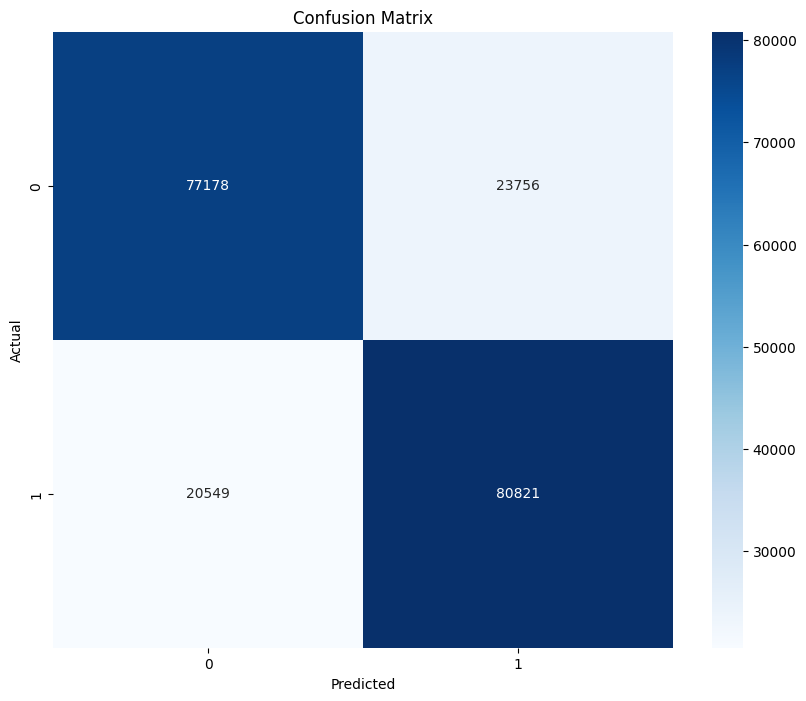

In [9]:
test_path = "/kaggle/input/sarcasm-test/test.csv"
best_ckpt = "/kaggle/input/sarcasm-detector/pytorch/default/1/sarcasm_gcn_lstm_detector_best.pt"

# Load model architecture + weights
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SarcasmGCNLSTMDetector().to(device)
model.load_state_dict(torch.load(best_ckpt, map_location=device))

# Run evaluation (no re-training)
test_results = evaluate_test_set(
    test_file_path=test_path,
    model_path=best_ckpt,
    batch_size=8
)

print("Test set results:", test_results)